<a href="https://colab.research.google.com/github/sanujsriv/_topic_models/blob/FoTo/Synced_FoTo_Keyw_EMB_SpikeSlab_KDD_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# from google import colab # works only in colab (prevents from accidentally deleting files from NMSU server)
def clear_colab():
  home_dir = os.getcwd()#'/content/'
  os.chdir(home_dir)
  !rm -r *

In [ ]:
home_dir = os.getcwd()
min_df = 0
perc_vocab = 0.7
d_data='bbc'  # reuters, twentynews, webkb, wos, crowdgender,bbc,searchsnippet,yahooanswers,agnews120k
dtype = 'short'
all_vocab = True # False
home_dir

'/content'

In [ ]:
!nvidia-smi

Thu Jan 27 16:09:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/
if d_data == "twentynews":
  !wget -N -c https://www.dropbox.com/s/7yj1yvzpw589018/twentynews_4000.zip
  !unzip twentynews_4000.zip

/content


#⬅️ **0. Just Run these..**

In [ ]:
#@title Imports
# from sympy.stats import RaisedCosine, density
# from nltk.corpus import stopwords
import pandas as pd
import re
from time import time
import numpy as np
import collections
import gc
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import shutil
# cos_sim = nn.CosineSimilarity(dim=-1,eps=1e-08)

### pickle
import pickle
!pip install pickle5
import pickle5
import bz2
import _pickle as cPickle


### plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sb
from matplotlib import pyplot as plt


#### torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
import subprocess


In [ ]:
#@title function : load / save pickle_obj

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_pkl5(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

def compressed_pickle(data,title):
  with bz2.BZ2File(title + '.pbz2', 'w') as f:
    cPickle.dump(data, f)

def decompress_pickle(file):
 data = bz2.BZ2File(file+'.pbz2', 'rb')
 data = cPickle.load(data)
 return data

## **Download Data (Short & Full Documents)**

In [ ]:
def short_text_datasets():
  if not os.path.exists("VLDB_WTM_Datasets.zip"):
    !wget -N -c https://www.dropbox.com/s/0vzwa9eagkmgi0q/VLDB_WTM_Datasets.zip
    !unzip -o VLDB_WTM_Datasets.zip
    if all_vocab == True:
      if d_data == "bbc":
        dir ='/content/content/data_'+d_data
        shutil.rmtree(dir)
        !wget -N -c https://www.dropbox.com/s/2ow6rn3xgtpg6uq/bbc_all_vocab_.zip
        !unzip bbc_all_vocab_.zip


In [ ]:
# def download_twenty_news():
#   !wget -N https://www.dropbox.com/s/09y9y1h0xk3cxaj/embeddings_twentynews.pkl
#   !wget -N https://www.dropbox.com/s/ewv3vcwgll0r8a7/data_twentynews_labels.pkl
#   !wget -N https://www.dropbox.com/s/chpjn9lzr7rmn2k/fixed_data_twentynews_preprocessed.pkl

In [ ]:
def download_reuters():
  !wget -N https://www.dropbox.com/s/8khmuj31il8zgkp/data_reuters_labels.pkl
  !wget -N https://www.dropbox.com/s/bgc1ht0jsyjed6s/embeddings_reuters.pkl
  !wget -N https://www.dropbox.com/s/9fk30bjzeefvhgl/data_reuters_preprocessed.pkl

In [ ]:
def download_webkb():
  !wget -N https://www.dropbox.com/s/wz88fk42r0viqvo/data_webkb_preprocessed.pkl
  !wget -N https://www.dropbox.com/s/8oi5qactwrar1ad/data_webkb_labels.pkl
  !wget -N https://www.dropbox.com/s/go7r4h39q6l01d5/embeddings_webkb.pkl

In [ ]:
def download_WoS():
  # !wget -N -c https://www.dropbox.com/s/3bse48k5kjpt5zd/wos_full_short_all_vocab.zip
  # !unzip -o wos_full_short_all_vocab.zip
  !wget -N -c https://www.dropbox.com/s/td8vf1lqmau41vn/wos_full_iter200_sent.zip
  !unzip -o wos_full_iter200_sent.zip

  # !wget -N https://www.dropbox.com/s/c6wlr148lhwsbaz/embeddings_wos.pkl
  # !wget -N https://www.dropbox.com/s/j96061ln6oeejkf/data_wos_preprocessed.pkl
  # !wget -N https://www.dropbox.com/s/kiffa4nidkjt7wi/data_wos_labels.pkl

In [ ]:
def download_unzip_crowdgender():
  !wget -N https://www.dropbox.com/s/trz5uph29b0t0eg/data_crowder.zip
  os.system('unzip data_crowder.zip')

In [ ]:
def download_data(data,dtype):
  data = data.lower()
  dtype = dtype.lower()
  if data == 'reuters':
    download_reuters()
  elif data == 'crowdgender':
   download_unzip_crowdgender()
  elif data == 'webkb':
    download_webkb()
  elif data == 'wos':
    download_WoS()
  # elif dtype == 'short':
  #   short_text_datasets()

  elif data == 'searchsnippet' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/vu3ftyv72fodfiv/searchsnippet_all_vocab_.zip
    !unzip -o searchsnippet_all_vocab_.zip
  elif data == 'agnews120k' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/wvx9ed1rop9vjkg/agnews120k_all_vocab_.zip
    !unzip -o agnews120k_all_vocab_.zip
  elif data=='bbc' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
    !unzip -o bbc_short_all_vocab_.zip
  elif data=='bbc' and dtype =='full' and all_vocab:
    # dir ='/content/content/data_'+d_data
    # shutil.rmtree(dir)
    # !wget -N -c https://www.dropbox.com/s/e2ftkdd742chouz/bbc_full_short_all_vocab_.zip
    # !unzip -o bbc_full_short_all_vocab_.zip
    !wget -N -c https://www.dropbox.com/s/t217pxhn280njre/bbc_full_all_vocab_200iter_sent.zip
    !unzip -o bbc_full_all_vocab_200iter_sent.zip

##**Data Loading functions**

In [ ]:
def load_data(d_data,dtype,generated):
  dir= home_dir+'/content/data_'+d_data+'/'+dtype
  # dir ='/content/content/data_'+d_data+'/'+dtype
  os.chdir(dir)
  data_preprocessed=load_obj_pkl5("data_preprocessed_"+d_data+"_"+dtype)
  data_preprocessed_labels=load_obj_pkl5("data_preprocessed_labels_"+d_data+"_"+dtype)
  if generated == False:
    embeddings=load_obj_pkl5("embeddings_"+d_data+"_"+dtype)
  # generated_embeddings=load_obj_pkl5("generated_embeddings_"+d_data+"_"+dtype)
  elif generated==True:
    embeddings = load_obj_pkl5("generated_embeddings_"+d_data+"_"+dtype)
  os.chdir(home_dir)
  return data_preprocessed,data_preprocessed_labels,embeddings,load_data.__name__

def load_20News_sentences():
  embeddings = load_obj('embeddings_twentynews_sent')
  data_preprocessed = load_obj('data_twentynews_preprocessed_sent')
  data_preprocessed_labels = load_obj("data_twentynews_labels_sent")
  doc_sent_id = load_obj('doc_id_sent_twentynews')
  return data_preprocessed,data_preprocessed_labels,embeddings,doc_sent_id,load_20News_sentences.__name__

def load_20News_reuters():
  data_preprocessed = load_obj('data_reuters_preprocessed')
  data_preprocessed_labels = load_obj("data_reuters_labels")
  embeddings = load_obj('embeddings_reuters')
  data_preprocessed.extend(load_obj('data_20News_preprocessed'))
  data_preprocessed_labels.extend(load_obj("data_20news_preprocessed_labels"))
  embeddings.update(load_obj('embeddings_20news'))
  return data_preprocessed,data_preprocessed_labels,embeddings,load_20News_reuters.__name__

## get_keywords

In [ ]:
def get_keywords(data):
  keywords_arxiv = ['molecular ','stimulation','liquid','fluid']
  keywords_webkb = ['student','department','india']
  keywords_r52 = ['mutual','fund','market','money']

  keywords_WoS = ['pediatric','protein','clone']
  keywords_20News_Reuters = ['oil','price','opec','bpd','barrel','saudi','production','mln','crude']

  # keywords_reuters = ['company', 'analyst', 'offer', 'pct', 'takeover', 'merger', 'record', 'dividend', 'pay', 'stock']
  # keywords_reuters = ['stock', 'dividend', 'inc']
  keywords_reuters = ['oil','crude','ship']
  # keywords =['stock']
  # keywords_reuters = ['usa']

  keywords_crowdgender = ['housewife','girl','beautiful','blonde']

  keywords_20News = ['sport','game','baseball']
  # keywords_20News = ['looking' ,'add', 'voice' ,'input', 'capability', 'user', 'interface']

  # keywords_bbc=['fuel','reserve','oil']
  # keywords_bbc=['fuel','oil','game','win']
  # keywords_bbc=['fuel','oil','crude']
  # keywords_bbc=['fuel','usa'] #,'politics'
  # keywords_bbc = ['stock','apple','increase']
  # keywords_bbc = ['microsoft','computer']
  # keywords_bbc = ['food','mcdonald']
  keywords_bbc = ['apple','microsoft', 'stock']
  # keywords_bbc = ['apple','stock']
  # keywords_bbc = ['fuel']
  # keywords_bbc = ['microsoft','fuel']
  # keywords_bbc = ['apple','microsoft','stock']


  # keywords_searchsnippet = ['politics','drama','minister']
  keywords_searchsnippet = ['korean','drama']


  keywords_yahooanswers = ['anger','hate','crime']
  # keywords_agnews = ['computer','apple','microsoft']
  keywords_agnews = ['auto','gasoline']

  data = data.lower()
  if data=='reuters': keywords = keywords_reuters
  elif data=='twentynews':keywords = keywords_20News
  elif data=='crowdgender':keywords = keywords_crowdgender
  elif data=='webkb':keywords = keywords_webkb
  elif data=='bbc': keywords = keywords_bbc
  elif data=='searchsnippet': keywords = keywords_searchsnippet
  elif data=='yahooanswers': keywords = keywords_yahooanswers
  elif data=='agnews120k': keywords = keywords_agnews
  elif data=='wos': keywords = keywords_WoS
  else:
    print('keyword list not found!!!')
  return keywords

##DESM Score Function

In [ ]:
def cosine_similarity_desm_docs(query_list, train_vec, vocab, embeddings):
  num_docs = train_vec.shape[0]
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      if(train_vec[d][v] > 0):
        doc_bar.add_(train_vec[d][v] * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec[d][v]
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list

In [ ]:
def cosine_similarity_desm_docs_forlarge(query_list, train_vec, vocab, embeddings):
  num_docs = train_vec.shape[0]
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      train_vec_val = train_vec[d].toarray()[0][v]
      if(train_vec_val > 0):
        doc_bar.add_(train_vec_val * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec_val
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list


## functions (Plot_loss, get_topwords, get_Z, get_Contour, print_Topics)

In [ ]:
def getall_tensor_size():
  for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(),get_mem_size(obj))
    except:
        pass

def list_of_tensors_to_tensor(loT):
  stacked_tensor = torch.stack(loT)
  return stacked_tensor

def get_labels_dict(unique_labels):
  labels_dict = {}
  for l in unique_labels:
    labels_dict[l] = 'C'+str(unique_labels.index(l))
  return labels_dict

def get_topwords(beta, id_vocab,topwords):
    topic_indx = 0
    topwords_topic = []
    topic_topwords = topwords
    for i in range(len(beta)):
        topwords_topic.append( str(topic_indx)+": "+ " ".join([id_vocab[j] for j in beta[i].argsort()[:-topic_topwords - 1:-1]]))
        topic_indx+=1
    return topwords_topic

def print_Topics(topwords):
  print("---"*10)
  topword_topics = get_topwords(beta, id_vocab,topwords)
  topword_topics_list=[]
  for topwords in topword_topics:
      topword_topics_list.append(topwords.split())
      print(topwords)
  print("---"*10)

In [ ]:
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

def plot_fig(zx, labels_list, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    label_colors_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=label_colors_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    # ax.text(query_center[0],query_center[1], 'X' ,c='red')
    # ax.text(0,0, 'X' ,c='black')
    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))



def get_Z(X,Y):
  norms = torch.zeros(X.shape)
  Z = torch.zeros(X.shape)

  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      v = torch.tensor([X[i][j],Y[i][j]])

      norms[i][j] = torch.norm(v)
      Z[i][j]=torch.exp(-0.5 * (torch.pow(norms[i][j],2))/mu_div)

      # norms[i][j] = (v-query_center.T).pow(2).sum(-1)
      # Z[i][j]=torch.exp(-0.5 * norms[i][j]/mu_div)
  return Z

def get_Contour(ax,x_list,lim):
  xlist = np.linspace(-lim, lim, 200)
  ylist = np.linspace(-lim, lim, 200)
  X, Y = np.meshgrid(xlist, ylist)
  Z = get_Z(X,Y)
  levels = np.arange(0,1,0.1)
  cp = ax.contour(X, Y, Z, levels=levels)
  ax.clabel(cp, inline=1, fontsize=10)


def get_gpu_memory_map():
    """Get the current gpu usage.
    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = np.array([int(x) for x in result.strip().split('\n')])
    # gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory

def auto_select_gpu(memory_threshold = 7000, smooth_ratio=200, strategy='greedy'):
    gpu_memory_raw = get_gpu_memory_map() + 10
    if strategy=='random':
        gpu_memory = gpu_memory_raw/smooth_ratio
        gpu_memory = gpu_memory.sum() / (gpu_memory+10)
        gpu_memory[gpu_memory_raw>memory_threshold] = 0
        gpu_prob = gpu_memory / gpu_memory.sum()
        cuda = str(np.random.choice(len(gpu_prob), p=gpu_prob))
        print('GPU select prob: {}, Select GPU {}'.format(gpu_prob, cuda))
    elif strategy == 'greedy':
        cuda = np.argmin(gpu_memory_raw)
        print('GPU mem: {}, Select GPU {}'.format(gpu_memory_raw[cuda], cuda))
    return cuda

## Just Run (pytorch)

In [ ]:
#@title Weight Drop
def _weight_drop(module, weights, dropout):
    """
    Helper for `WeightDrop`.
    """
    for name_w in weights:
        w = getattr(module, name_w)
        del module._parameters[name_w]
        module.register_parameter(name_w + '_raw', Parameter(w))

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        for name_w in weights:
            raw_w = getattr(module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=dropout, training=module.training)

            setattr(module, name_w, w)

        # return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)


class WeightDrop(torch.nn.Module):
    """
    The weight-dropped module applies recurrent regularization through a DropConnect mask on the
    hidden-to-hidden recurrent weights.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        module (:class:`torch.nn.Module`): Containing module.
        weights (:class:`list` of :class:`str`): Names of the module weight parameters to apply a
          dropout too.
        dropout (float): The probability a weight will be dropped.

    Example:

        >>> from torchnlp.nn import WeightDrop
        >>> import torch
        >>>
        >>> torch.manual_seed(123)
        <torch._C.Generator object ...
        >>>
        >>> gru = torch.nn.GRUCell(2, 2)
        >>> weights = ['weight_hh']
        >>> weight_drop_gru = WeightDrop(gru, weights, dropout=0.9)
        >>>
        >>> input_ = torch.randn(3, 2)
        >>> hidden_state = torch.randn(3, 2)
        >>> weight_drop_gru(input_, hidden_state)
        tensor(... grad_fn=<AddBackward0>)
    """

    def __init__(self, module, weights, dropout=0.0):
        super(WeightDrop, self).__init__()
        _weight_drop(module, weights, dropout)
        self.forward = module.forward

class WeightDropLinear(torch.nn.Linear):
    """
    Wrapper around :class:`torch.nn.Linear` that adds ``weight_dropout`` named argument.

    Args:
        weight_dropout (float): The probability a weight will be dropped.
    """

    def __init__(self, *args, weight_dropout=0.0, **kwargs):
        super().__init__(*args, **kwargs)

        weights = ['weight']
        # print('name_w in _weight_drop: ', name_w)
        _weight_drop(self, weights, weight_dropout)

In [ ]:
# @title Targeted Dropout Class
import torch
import torch.nn as nn


class TargetedDropout(nn.Module):
    """
    Learning Sparse Networks Using Targeted Dropout
    https://arxiv.org/abs/1905.13678
    """

    def __init__(self,targeted="weight",target_layer=None,
                 dropout_rate=0.5,targeted_portion=0.5):
        super(TargetedDropout, self).__init__()
        self.targeted = targeted
        self.target_layer = target_layer
        self.dropout_rate = dropout_rate
        self.targeted_portion = targeted_portion
        self.weight = target_layer.weight

        if self.targeted == "weight":
            self.targeted_dropout = targeted_weight_dropout
        elif self.targeted == "unit":
            self.targeted_dropout = targeted_unit_dropout

    def forward(self):
        self.weight = self.targeted_dropout(
            weight=self.target_layer.weight,
            dropout_rate=self.dropout_rate,
            targeted_portion=self.targeted_portion,
            is_training=self.training,
        )

        self.target_layer.weight = self.weight
        # output = self.target_layer(x)
        return self.weight

    def extra_repr(self):
        return f"targeted={self.targeted}, dropout_rate={self.dropout_rate}, targeted_portion={self.targeted_portion}"


def targeted_weight_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.abs(weight)
    idx = int(targeted_portion * torch.tensor(weight.shape[0]).float())
    threshold = torch.sort(norm, dim=0)[0][idx]
    mask = norm < threshold[None, :]

    if not is_training:
        mask = (torch.rand_like(weight) < dropout_rate).to(mask.device.type) & mask

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

def targeted_unit_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.norm(weight, dim=0)
    idx = int(targeted_portion * int(weight.shape[1]))
    sorted_norms = torch.sort(norm)[0]
    threshold = sorted_norms[idx]
    mask = (norm < threshold)[None, :]
    mask = mask.repeat(weight.shape[0], 1)

    if not is_training:
        mask = torch.where(
            ((1.0 - dropout_rate) < torch.rand_like(weight)).to(mask.device.type)
            & mask,
            torch.ones_like(weight, dtype=torch.float32),
            torch.zeros_like(weight, dtype=torch.float32),
        )

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

# **1. Prepare Data**

In [ ]:
#### Data Downloading ####
download_data(d_data,dtype) ### Run Once

--2022-01-27 16:09:23--  https://www.dropbox.com/s/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip [following]
--2022-01-27 16:09:23--  https://www.dropbox.com/s/raw/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5d72cef2ae6cb63cf7b44fd53a.dl.dropboxusercontent.com/cd/0/inline/BelARyIyu9ko4G_VJCgrm8K5oKC30tUWt8a1sD24GFWIWEJlW9GcAMuhlvRKjg-XKlfFeynGWOHfbUugjtiieX7XjWhWKxDd8Iz-dGzbUXYeGexJSQSg4fwsaaOxM0ylU3znSmowcAG04jxhcwWDuLeX/file# [following]
--2022-01-27 16:09:23--  https://uc5d72cef2ae6cb63cf7b44fd53a.dl.dropboxusercontent.com/cd/0/inline/BelARyIyu9ko4G_VJCgrm8K5oKC30tUWt8a1sD24GFWIWEJlW9G

In [ ]:
# ##### Data loading #####
# dtype='short'
loaded_data = load_data(d_data,dtype,generated=True)
##########################

data_preprocessed , data_preprocessed_labels , embeddings, name = loaded_data
max_features=int(len(embeddings)*perc_vocab)
# if len(embeddings)>10000:
#   max_features = 10000
sorted_unique_labels = sorted(set(data_preprocessed_labels))

# for d in range(len(data_preprocessed)):
#   data_preprocessed[d] = doc_remove_extra_stopwords(data_preprocessed[d])
print(name,d_data,len(data_preprocessed_labels),len(data_preprocessed),len(embeddings),max_features)

load_data bbc 2224 2224 5733 4013


In [ ]:
data_islarge = False
preprossed_data = data_preprocessed
train_label = data_preprocessed_labels
vectorizer = CountVectorizer(min_df=min_df,max_features=max_features)
if len(preprossed_data) > 45000:
  data_islarge= True
  train_vec = vectorizer.fit_transform(preprossed_data)
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  train_label = np.asarray(train_label)
else:
  train_vec = vectorizer.fit_transform(preprossed_data).toarray()
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  nonzeros_indexes = np.where(train_vec.any(1))[0]
  train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]
  preprossed_data_non_zeros = [preprossed_data[i] for i in nonzeros_indexes]
  train_label = [data_preprocessed_labels[i] for i in nonzeros_indexes]

# train_vec = np.asanyarray(train_vec_non_zeros)
num_input = train_vec.shape[1]

print(train_vec.shape)
print(train_label)
print(vocab)

(2224, 4013)
['business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'b

In [ ]:
# tfidfvectorizer = TfidfVectorizer(min_df=min_df,max_features=max_features)
# tfidf_vec = tfidfvectorizer.fit_transform(data_preprocessed).toarray()

In [ ]:
keywords = get_keywords(d_data)

# commented for WoS
if data_islarge == True:# pass
  all_rscores = cosine_similarity_desm_docs_forlarge(keywords,train_vec,vocab,embeddings)
else:
  all_rscores = cosine_similarity_desm_docs(keywords,train_vec,vocab,embeddings)

0


In [ ]:
device = torch.device("cuda:"+str(auto_select_gpu()) if torch.cuda.is_available() else "cpu")
if data_islarge: pass
else: tensor_train_w = torch.from_numpy(train_vec).float()
train_label = np.asarray(train_label)

GPU mem: 12, Select GPU 0


# **2. Scores**

## DESM Score

In [ ]:
top_10_docs=[]
sort,indices = torch.sort(all_rscores,descending=True)
print('Keywords',keywords)
print('Descending :',sort,'\n','indices:',indices)
print('\n\n Top 10 Relevant Documents (DESM):\n\n',"---"*40)

for k in range(10):
   print(k+1,') ',preprossed_data_non_zeros[indices[k].item()])
   print(k+1,')',train_label[indices[k].item()])

with open("1000.txt", "w") as output:
  for k in range(0,1000):
    output.write(str(k+1)+') '+str(preprossed_data_non_zeros[indices[k].item()])+'\n')
    output.write(str(k+1)+') '+str(sort[k].item())+'\n')
    output.write(str(k+1)+') '+str(train_label[indices[k].item()])+'\n')
output.close()

scaler = MinMaxScaler(feature_range=(0+1e-10, 0.99))
normalized_all_rscores = scaler.fit_transform(all_rscores.data.reshape(-1,1))
normalized_all_rscores=torch.tensor(normalized_all_rscores.flatten())

sorted_docs, sorted_idxs = torch.sort(normalized_all_rscores,descending=True)
rounded_normalized_all_rscores = torch.round(normalized_all_rscores*10)/10.0

Keywords ['apple', 'microsoft', 'stock']
Descending : tensor([0.5192, 0.5192, 0.5033,  ..., 0.1512, 0.1399, 0.1333]) 
 indices: tensor([1862, 2154, 1970,  ...,  709,  716,  683])


 Top 10 Relevant Documents (DESM):

 ------------------------------------------------------------------------------------------------------------------------
1 )  apple ipod family expands market apple expanded ipod family release generation digital music player
1 ) tech
2 )  apple ipod family expands market apple expanded ipod family release generation digital music player
2 ) tech
3 )  itunes user sue apple ipod user apple itunes music service suing firm unfair ipod play song
3 ) tech
4 )  microsoft release bumper patch microsoft warned user update system latest security flaw window program
4 ) tech
5 )  microsoft release patch microsoft warned user update system latest security flaw window program
5 ) tech
6 )  mobile music challenge ipod age nokia microsoft agreed deal work delivery music handset sony er

In [ ]:
# plt.hist(normalized_all_rscores)

In [ ]:
# plt.hist(rounded_normalized_all_rscores)

In [ ]:
from collections import defaultdict

contains_key = 0
doc_contains__anykey_idx = []
for doc in preprossed_data_non_zeros:
  for k in keywords:
    if k in doc:
      contains_key += 1
      doc_contains__anykey_idx = np.append(doc_contains__anykey_idx,preprossed_data_non_zeros.index(doc)).astype(int)
      break

doc_contains_anykey = torch.zeros(train_vec.shape[0])
doc_contains_anykey[doc_contains__anykey_idx] = 1.0
# doc_contains_anykey = torch.zeros(tensor_train_w.size())
# for idx in doc_contains__anykey_idx:
#     doc_contains_anykey[idx][torch.where(tensor_train_w[idx]>0)[0]] = 1.0

def get_relv_words(docs_keys_idx,preprossed_data_non_zeros,vocab):
  relv_words  = []
  for d in docs_keys_idx:
    relv_words.extend(preprossed_data_non_zeros[d].split(' '))
  idx_relv_words = np.asarray(list(set([vocab[r] for r in relv_words])))
  return idx_relv_words

## Approach 1 - All words only in the docs containing the keyword are relevant  (.)

## Approach 2 - All words in the docs containing the keyword are relevant i.e. the same words if appear in other docs are relevant  (X)
N_V_relv_doc_cOnkey = torch.zeros(tensor_train_w.size())

doc_contains_keyidx = defaultdict(list)
for k in keywords:
  for doc in preprossed_data_non_zeros:
    if k in doc:
      dk_idx = preprossed_data_non_zeros.index(doc)
      doc_contains_keyidx[k].append(dk_idx)
      N_V_relv_doc_cOnkey[dk_idx][torch.where(tensor_train_w[dk_idx]>0)[0]] = 1.0 #  All words only in the docs containing the keyword are relevant


# idx_allkeys_relvWord = get_relv_words(doc_contains__anykey_idx,preprossed_data_non_zeros,vocab)
# idx_keys_relvWord = {}
# for k in keywords:
#   idx_keys_relvWord[k] =  get_relv_words(doc_contains_keyidx[k],preprossed_data_non_zeros,vocab)  # docs containing the keyword are relevant i.e. the same words if appear in other docs are relevant

In [ ]:
gc.collect()

202

In [ ]:
# import torch

# def log_bmm(a,b):
#     """Performs a batch matrix-matrix product of matrices in log-space.
#     Args:
#         a: tensor with shape (b, n, m)
#         b: tensor with shape (b, m, p)
#     Returns:
#         tensor with shape (b, n, p)
#     """
#     assert a.ndim == b.ndim == 3
#     assert a.size(0) == b.size(0)
#     assert a.size(2) == b.size(1)

#     bsz, p, m = a.size()
#     _, _, n = b.size()
#     a1 = a.unsqueeze(2).expand(bsz, p, n, m)
#     b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
#     return torch.logsumexp(a1 + b1, dim=-1)

# a = torch.ones(10,5,20) * 5
# b = torch.ones(10,7,5) * 3

# log_bmm(a,b)

## Cosine Score

In [ ]:
cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
torch.pi = torch.acos(torch.zeros(1)).item() * 2
# model 5.3
sig_exp_dist = 50.0


def flatten_list(user_list): return [item for sublist in user_list for item in sublist]
def get_embedding_tensor(word_list,embeddings): return torch.tensor([embeddings[w] for w in word_list])


def cosine_angular_sim(keyword_torch,words_tensor): return 1 - (torch.acos(cos_sim(keyword_torch,words_tensor))) / torch.pi
def cosine_norm_01(keyword_torch,words_tensor): return (cos_sim(keyword_torch,words_tensor) + 1.0)/2.0
def cosine_sqrt(keyword_torch,words_tensor): return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**0.5
def euclidean_dist(keyword_torch,words_tensor) : return ((words_tensor-keyword_torch).pow(2).sum(-1))**0.5

def edist(x,x1):
  dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = torch.exp(-dist/0.1)
  return dist_sim


def inv_new_fn(x,x1):
  beta = 3
  dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = 1.0 / (1.0 + (dist/(1-dist))**(-beta))
  return dist_sim

def exp_dist_sim_x_x1(x,x1,sig=sig_exp_dist):
  # sig = 0.1
  dist = torch.pow((x-x1),2).sum(-1)
  # dist2 = torch.norm((x-x1),dim=-1)**2
  exp_dist_sim = torch.exp(- dist / sig)
  return exp_dist_sim

def get_dist_val_score(f,keyword_torch,words_tensor):
  score = f(keyword_torch,words_tensor)
  return score

def cosine_keywords(keywords,words_tensor,word_list,similarity_function):
  all_keywords_score = []
  all_cosine_sim = []
  all_dist = []
  cosine_score_vocab = {}
  keyword_total_score = torch.zeros(words_tensor.shape[0])
  for k in keywords:
    keyword_torch = torch.from_numpy(embeddings[k])
    keyword_torch = keyword_torch.unsqueeze(0).expand(words_tensor.shape[0],words_tensor.shape[1])

    cosine_sim_score = cos_sim(keyword_torch,words_tensor)
    score = get_dist_val_score(similarity_function,keyword_torch,words_tensor)
    # cosine_score = cosine_sqrt(keyword_torch,words_tensor)
    # cosine_score = cosine_angular_sim(keyword_torch,words_tensor)
    # cosine_score = cosine_norm_01(keyword_torch,words_tensor)

    # cosine_score[idx_keys_relvWord[k]] = 1.0
    all_keywords_score.append(score)
    all_cosine_sim.append(cosine_sim_score)

    # dist_sim_val,dist_val = exp_dist_sim_x_x1(words_tensor,keyword_torch,sig_exp_dist)
    # dist_sim_val,dist_val = edist(keyword_torch,words_tensor,sig_exp_dist)

    # dist_sim_val[idx_keys_relvWord[k]] = 1.0
    # all_keywords_score.append(dist_sim_val)
    # all_dist.append(dist_val)

    keyword_total_score += cosine_sim_score
  keywords_max_score,keyword_max_score_idx = torch.max(torch.stack(all_keywords_score),dim=0)
  cosine_score_vocab = dict(zip(word_list,keywords_max_score.numpy()))

  return all_keywords_score,keyword_total_score/len(keywords),keywords_max_score,cosine_score_vocab,all_cosine_sim

In [ ]:
sorted_id_word_vocab = sorted(id_vocab.items(), key=lambda x: x[1]) ### alphabetically sorted
word_list = [s[1] for s in sorted_id_word_vocab]
words_tensor = get_embedding_tensor(word_list,embeddings)

# sorted_cosine_words_vocab = sorted(cosine_score_vocab.items(), key=lambda x: x[1]) ### cosine sim score sorted
# sorted_cosine_vocab = [s[0] for s in sorted_cosine_words_vocab]

embedding_tensor_sorted_alp = get_embedding_tensor(word_list,embeddings)
embedding_tensor_keywords = get_embedding_tensor(keywords,embeddings)
similarity_function = cosine_sqrt # exp_dist_sim_x_x1 # << your similarity function here
all_keywords_score,keywords_mean_score,keywords_max_score,cosine_score_vocab,all_cosine_sim = cosine_keywords(keywords,words_tensor,word_list,similarity_function)


idx_where_0 = torch.where(keywords_max_score <= 0.45)[0]
cosine_flag_testing = keywords_max_score.clone()
cosine_flag_testing[idx_where_0] = 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
key_idx = np.array([vocab[k] for k in keywords])

def min_max_norm_1(cosine_val):
  min_v = torch.min(cosine_val)
  # max_v = torch.topk(cosine_val,k=len(keywords)+1).values[-1]
  max_v = torch.max(cosine_val)
  # max_v=torch.max(cosine_val)
  val = (cosine_val - min_v) / ( (max_v - min_v) )
  # for i in range(len(key_idx)):
  #   val[key_idx[i]] = 1.0
  return val

In [ ]:
# val = min_max_norm_1(list_of_tensors_to_tensor(all_cosine_sim),key_idx)
# threshold_focus = 0.0

# most_sim_key_V_K1 = torch.zeros(num_input,len(keywords))
# filter = torch.zeros(num_input)

# for i in range(num_input):
#   maximum,index = torch.max(val[:,i],-1)
#   if(maximum>threshold_focus):
#     most_sim_key_V_K1[i][int(index)] = 1.0
#     filter[i] = 1

In [ ]:
####@title Threshold focus (quantile)
threshold_focus_quantile = 0.5 #@param {type:"slider", min:0.1, max:1.0, step:0.05}

# val = min_max_norm_1(list_of_tensors_to_tensor(all_cosine_sim))
# val = (list_of_tensors_to_tensor(all_cosine_sim))
val = (list_of_tensors_to_tensor(all_keywords_score))
a = val
q = torch.tensor([threshold_focus_quantile])#0.25, 0.5, 0.75])
q_v = torch.quantile(a, q, dim=1, keepdim=True)[0]

most_sim_key_V_K1 = torch.zeros(num_input,len(keywords)+1)
# most_sim_key_V_K1 = torch.zeros(num_input,len(keywords))
filter = torch.zeros(num_input)

for i in range(num_input):
  maximum,index = torch.max(val[:,i],-1)
  # minimum,index = torch.min(val[:,i],-1)
  #q_v[index][0] = 0.1
  if(maximum>q_v[index][0]):
  # if(minimum<q_v[index][0]):

    most_sim_key_V_K1[i][int(index)] = 1.0
    filter[i] = 1
  else:
    most_sim_key_V_K1[i][len(keywords)] = 1.0
    filter[i] = 1

In [ ]:
# word_list[vocab['apple']]

(array([ 3.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0., 11.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

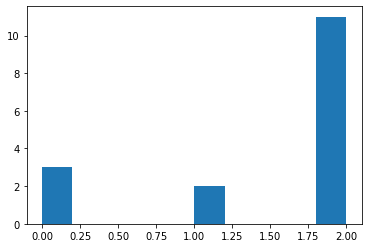

In [ ]:
k=232
keywords_and_dummy = keywords+['dummy']
idx_list = []
all_w= []
doc_words = data_preprocessed[k].split(' ')
for d in doc_words:
  if d in word_list:
    all_w.append(d)
    idx_list.append(torch.where(most_sim_key_V_K1[vocab[d]]==1)[0].item())
  else: pass
idx_list
#   if d in word_list:
#     idx_list.append(word_list.index(d))
# idx_ar = np.asarray(idx_list)
# vals , idxs = torch.where(most_sim_key_V_K1[idx_ar]==1)
# vals = vals.numpy()
# idxs = idxs.numpy()


# for i in range(len(all_w)):
#     print(all_w[i]," : ",keywords_and_dummy[idx_list[i]])
plt.hist(idx_list)

In [ ]:
# STOP!!

In [ ]:
# plt.hist(val[0])
# torch.median(val[0])

In [ ]:
# N_K_for_docs = []
# for doc in preprossed_data_non_zeros:
#   key_in_doc = []
#   for k in keywords:
#     if k in doc:
#       key_in_doc.append(1)
#     else:
#       key_in_doc.append(0)
#   key_in_doc.append(0) # comment this for N_K_V_key_doc_bernoulli
#   N_K_for_docs.append(key_in_doc)
# N_K_for_docs_t = torch.tensor(np.asarray(N_K_for_docs))
# #
# # size = (len(preprossed_data_non_zeros) , len(get_keywords(d_data)), num_input)
# # all_key_score_t = list_of_tensors_to_tensor(all_keywords_score)
# # N_K_for_docs_t_expanded = N_K_for_docs_t.unsqueeze(-1).expand(size)
# # N_K_V_key_doc_bernoulli =  all_key_score_t ** N_K_for_docs_t_expanded

# # for i in range(len(N_K_V_key_doc_bernoulli)):
# #   for j in range(len(keywords)):
# #     N_K_V_key_doc_bernoulli[i][j][torch.where(tensor_train_w[i]==0)[0]] = 0.0

In [ ]:
# print('median : ',np.median(keywords_max_score))
# print('\n\nCosine score (words closest to keywords)\n')
# plt.hist(all_keywords_score[0])

# **FoTo**

In [ ]:
##@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w,pow)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  smoothen = 1e-8
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

In [ ]:
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

array([2])

In [ ]:
# heatmap visualization
# test which beta works best
# set of query (top and bottom half)
# use full vocab?? (use top 70%)
# run TTM

In [ ]:
##@title Model 5.5.7 (key-dep theta softmax | min max norm | Dummy )

num_topic = 15
bs = 256 # for searchsnippet short all docs all vocab
 ## WOS : for short 8192 for full 5120
# bs = 4096 ## WOS NMSU Server full 4096
drop_rate = 0.2
epochs = 1000
mu_div=300.0

sig=100.0
sig_gauss = 0.1
sig_ring = 0.1

is_KLD = True

smoothen=1e-30
# smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()

#phi
def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        self.embeddings_keys = embedding_keywords

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)

        # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0
        self.en2_drop_mu_z   = nn.Dropout(drop_rate)

        # mapping network for keyword coordinates
        self.k1_fc     = nn.Linear(300, 100)
        self.k2_fc     = nn.Linear(100, 100)
        self.k_fc = nn.Linear(100, 2)
        self.keyword_coords = 0
        self.en2_drop_keyw   = nn.Dropout(drop_rate)

        # Model paramters
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.keywords_w_dummy_shape = self.num_keyword+1

        # self.mu_z = nn.Parameter(torch.Tensor(self.num_topic, self.word_emb_size))
        # self.keyword_coords = nn.Parameter(torch.Tensor(self.keywords_w_dummy_shape, self.in_features)) # K+1 x 2

        self.query_center = nn.Parameter(torch.zeros(2,1))
        self.dummy_keyword = nn.Parameter(torch.Tensor(1,self.word_emb_size))# 1 x 300
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))
        self.beta_k_bias = nn.Parameter(torch.Tensor(self.out_features,self.keywords_w_dummy_shape))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        if distance=="inverse_multi_quadric": self.basis_func = inverse_multi_quadric
        self.init_parameters()

        # decoder batch normalization layers

        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.decoder_bn_key = nn.BatchNorm1d(self.keywords_w_dummy_shape)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.01)
        # nn.init.normal_(self.mu_z, 0, 0.01)
        # nn.init.normal_(self.keyword_coords,0,0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)
        nn.init.normal_(self.beta_k_bias, 0, 0.01)
        nn.init.normal_(self.dummy_keyword, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_):
        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_key_dep_theta(self):

      N, *_ = self.z.size()

      zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
      # zx = self.z.view(N, 1, self.num_coordinate)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      # cos_sc = get_cosine_score(k=self.dummy_keyword,w=self.embedding_words,pow=0.5)
      # max_idx = torch.argmax(cos_sc)
      # self.key_and_dummy_emb = torch.cat((self.embeddings_keys,self.embedding_words[max_idx].unsqueeze(0)),0)

      self.key_and_dummy_emb = torch.cat((self.embeddings_keys,self.dummy_keyword),0) # self.embeddings_keys

      k1 = F.relu((self.k1_fc(self.key_and_dummy_emb)))                           # keyword mapping
      k2 = F.relu((self.k2_fc(k1)))
      self.keyword_coords = self.k_fc(k2)

      k = self.decoder_k_bn(self.keyword_coords)
      # k = self.decoder_phi_bn(self.keyword_coords)
      # k = self.keyword_coords

      doc_topic_size = (N, self.out_features, self.in_features) # NxTx2
      topic_key_size = (self.num_topic, self.keywords_w_dummy_shape, self.in_features) # TxK+1x2
      doc_key_size = (N,self.keywords_w_dummy_shape,self.in_features) # NxK+1x2

      x = zx.expand(doc_topic_size)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

      c_key = zc.view(self.num_topic,1, self.num_coordinate).expand(topic_key_size) # TxK+1x2
      k_topic = k.view(1, self.keywords_w_dummy_shape, self.num_coordinate).expand(topic_key_size) #TxK+1x2

      x_key = zx.expand(doc_key_size)
      k_doc = k.view(1, self.keywords_w_dummy_shape, self.num_coordinate).expand(doc_key_size)

      d_doc_topic = (x-c).pow(2).sum(-1)
      d_key_topic = (c_key-k_topic).pow(2).sum(-1)
      d_doc_key  = (x_key - k_doc).pow(2).sum(-1)

      distances_doc_topic = self.basis_func(d_doc_topic)
      distances_key_topic = self.basis_func(d_key_topic)
      distance_doc_key = self.basis_func(d_doc_key)

      self.dist_doc_key = d_doc_key
      self.dist_key_topic = d_key_topic
      self.dist_doc_key_basis_func = distance_doc_key

      doc_key_softmax = torch.exp(distance_doc_key - torch.logsumexp(distance_doc_key, dim=-1, keepdim=True)) # NxK
      self.topic_key_softmax = torch.exp(distances_key_topic - torch.logsumexp(distances_key_topic, dim=-1, keepdim=True)) # TxK

      add_size = (N,self.num_topic,self.keywords_w_dummy_shape)
      distances_doc_topic_expanded = distances_doc_topic.unsqueeze(-1).expand(add_size)
      distances_key_topic_expanded = distances_key_topic.unsqueeze(0).expand(add_size)

      key_dep_theta = torch.exp( (distances_doc_topic_expanded + distances_key_topic_expanded) - torch.logsumexp((distances_doc_topic_expanded + distances_key_topic_expanded), dim=1, keepdim=True))
      key_dep_theta_NT = torch.matmul(key_dep_theta,doc_key_softmax.unsqueeze(-1)).squeeze(-1) # NxTx(K+1) x  Nx(K+1)x1 --> (take sum across k) NxTx1 --> squeeze

      return key_dep_theta_NT , zx, d_doc_topic, c, zc, distances_doc_topic,distances_key_topic, N,doc_key_softmax


    def decode(self):
      key_dep_theta, zx, d, c, zc, distances, distances_k_c, N, doc_key_softmax = self.get_key_dep_theta()

      mu1 = F.relu((self.mu1_fc(zc)))  # topic mapping (F.relu, F.softplus)
      mu2 = F.relu((self.mu2_fc(mu1))) # self.en2_drop()
      self.mu_z = self.mu_fc(mu2)



      # ## 13 Jan
      # cos_score = torch.max((get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)),0).values


      # # 18 jan
      # cos_only_keys = get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)#[0:num_keyword,:]
      # # cos_score =  torch.max(cos_only_keys,0).values
      # cos_score = torch.max(self.norm_cos_score,0).values

      # last tried 26th Jan
      cos_only_keys = get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)[0:num_keyword,:]
      cos_score =  torch.max(cos_only_keys,0).values

      self.beta = F.softmax( torch.mm(self.mu_z, self.embedding_words.T) * cos_score,dim=-1) # Cosine Ranked Beta (short beta)

      # cos_score = torch.max((get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)),0).values # take min_max_norm_1? (NO just take normalized cosine)
      # self.cos_score = get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)

      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z, self.embedding_words.T).T).T * cos_score
      #                       + self.beta_bias,dim=-1)

      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z, self.embedding_words.T).T).T * cos_score,dim=-1)
      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_score + self.beta_bias,dim=-1) # Cosine Ranked Beta + beta_bias



      ## more focused bad visualization ( # Tx300 * Kx300 --> TxK --> TxK * KxV )
      # topic_key_pdist = torch.mm(self.mu_z, self.key_and_dummy_emb.T)
      # self.beta = F.softmax(self.decoder_bn(torch.mm(topic_key_pdist,self.cos_score).T).T,dim=-1) # Cosine Ranked Beta (long text)


      # self.beta = F.softmax((torch.mm(self.mu_z, self.embedding_words.T).T).T,dim=-1) # WTM Beta
      recon_v_relv = torch.mm(key_dep_theta,self.beta)

      return recon_v_relv, zx, key_dep_theta, doc_key_softmax

    def forward(self, input_,most_sim_key, word_filter,norm_cos_score, compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

        self.z = z
        self.most_sim_key = most_sim_key
        self.word_filter = word_filter
        self.norm_cos_score = norm_cos_score

        recon_v_relv, zx, key_dep_theta, doc_key_softmax = self.decode()

        if compute_loss:
            return recon_v_relv,zx, self.loss(input_, recon_v_relv, most_sim_key, doc_key_softmax,key_dep_theta, posterior_mean, posterior_logvar, posterior_var,zx)
        else: return z, recon_v_relv, zx, key_dep_theta,doc_key_softmax

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, recon_v_relv, most_sim_key, doc_key_softmax,key_dep_theta, posterior_mean, posterior_logvar, posterior_var, zx, avg=True):
        N = posterior_mean.shape[0]

        # filter = self.word_filter.unsqueeze(0).expand(N,self.num_input)
        p_label = torch.mm(doc_key_softmax,most_sim_key.T) # N x V

        NL1 = - ((input_ * (recon_v_relv+smoothen).log())).sum(-1)
        NL2 = - ((input_ * (p_label+smoothen).log())).sum(-1)

        NL1 = NL1.sum()
        NL2 = NL2.sum()
        # NL2 = toT(0.0)
        NL = NL1 + NL2
        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()
        loss = NL + KLD
        return loss/N, NL,NL1,NL2, KLD

#**Train Model**

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords

num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords,emb_size,num_keyword, "inverse_quadratic") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

# >> pass params to forward (cosine , filter, etc..)

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter.to(device)
norm_cos_score = val.to(device)
# gaus_dist_w_k_device = gaus_dist_w_k.to(device)
for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0

    model.train()
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)

        labels = train_label[batch_ndx]

        recon_v, zx, (loss, loss_u,loss_NL1,loss_NL2, xkl_loss) = model(input_w,most_sim_key,word_filter,norm_cos_score,compute_loss=True)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()

    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || NL1==> {} || NL2==> {} || KLD==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch, loss_KLD))

    # ## Vis while training
    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # query_center = model.query_center.data.cpu().numpy()
    # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # query_words = (model.keyword_coords).data.cpu().numpy()
    # x_coord_train_list = np.array(x_coord_train_list)
    # labels_list = np.array(labels_list)
    # keyword_vis_labels = get_keywords(d_data)+['dummy']
    # if epoch %100 ==0:
    #   plot_fig(x_coord_train_list, labels_list, zphi,query_center,query_words=query_words,
    #      keywords=keyword_vis_labels,lim =20,contour='yes')

Epoch -> 0 , loss -> 1213.8534240722656
recon_loss==> 296410.798828125 || NL1==> 250786.787109375 || NL2==> 45624.01513671875 || KLD==> 3328.7382049560547
Epoch -> 10 , loss -> 1127.5115814208984
recon_loss==> 275682.263671875 || NL1==> 235911.8359375 || NL2==> 39770.426025390625 || KLD==> 2522.6986694335938
Epoch -> 20 , loss -> 1115.0398025512695
recon_loss==> 272764.55859375 || NL1==> 233261.765625 || NL2==> 39502.793701171875 || KLD==> 2359.3246154785156
Epoch -> 30 , loss -> 1108.7653121948242
recon_loss==> 271029.859375 || NL1==> 231823.193359375 || NL2==> 39206.66552734375 || KLD==> 2565.044708251953
Epoch -> 40 , loss -> 1103.6714782714844
recon_loss==> 269440.630859375 || NL1==> 230463.955078125 || NL2==> 38976.67724609375 || KLD==> 2870.4327697753906
Epoch -> 50 , loss -> 1100.4603652954102
recon_loss==> 268382.0859375 || NL1==> 229488.76953125 || NL2==> 38893.31689453125 || KLD==> 3158.418197631836
Epoch -> 60 , loss -> 1096.597396850586
recon_loss==> 267164.212890625 || NL1

# **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()
x_list = []
labels_list = []
doc_ids = []
zx_phi_list=[]
dist_doc_key = []
dist_doc_key_bfn = []
docs_rscore = []
with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]

        z, recon_v, zx, zx_phi,doc_key_softmax = model(input_w, most_sim_key, word_filter,norm_cos_score, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
        d_doc_key = model.dist_doc_key.data.detach().cpu().numpy()
        dist_doc_key_basis_func = model.dist_doc_key_basis_func.data.detach().cpu().numpy()

        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])
        zx_phi_list.extend(zx_phi)
        x_list.extend(zx)
        dist_doc_key.extend(d_doc_key)
        dist_doc_key_bfn.extend(dist_doc_key_basis_func)
        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))

    doc_ids = doc_ids.astype(int)
    x_list = np.array(x_list)
    labels_list = np.array(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)
    dist_doc_key = torch.tensor(np.array(dist_doc_key))
    dist_doc_key_bfn = np.array(dist_doc_key_bfn)

    beta = model.get_beta().data.cpu().numpy()

    zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()

    query_center = model.query_center.data.cpu().numpy()
    dist_key_topic = toT(model.dist_key_topic.data.detach().cpu().numpy())

    query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # query_words = model.keyword_coords.data.cpu().numpy()

In [ ]:
model.mu_z

tensor([[ 2.9457, -4.4040,  3.3352,  ...,  5.0890,  2.2290, -1.1887],
        [-0.5442,  0.0323, -0.7543,  ..., -2.4261,  3.5670,  0.2247],
        [-0.6912, -1.7966,  2.3897,  ..., -2.4183,  1.7384, -1.5530],
        ...,
        [ 1.0712, -4.3670, -0.1868,  ...,  0.4605,  0.3917, -1.3546],
        [ 0.2770, -2.5631, -2.1932,  ...,  0.4873,  1.2814,  0.7812],
        [ 2.8119, -4.9757,  0.9730,  ...,  2.0413,  0.6012, -0.7003]],
       device='cuda:0')

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

Jaccard sim b/w topics 2 and 3 is :  0.0


,appears
year,5
star,3
firm,3
top,2
election,2


In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

topic 1 - 8 tensor(0.9374, device='cuda:0')
topic 3 - 10 tensor(0.9751, device='cuda:0')
Cosine similarity b/w topic embeddings w score >=  0.9  | Count -  2


In [ ]:
keyword_vis_labels = get_keywords(d_data)+['dummy']
min_d_tk, min_d_tk_keyidx = torch.min(dist_key_topic,-1)
for i in range(num_topic):
  print("topic"+str(i)+" : ",keyword_vis_labels[min_d_tk_keyidx[i].item()])
print("Relv topics: ",len(torch.where(min_d_tk_keyidx !=len(keywords))[0]))
print("Irrelv topics: ",len(torch.where(min_d_tk_keyidx ==len(keywords))[0]))

topic0 :  stock
topic1 :  microsoft
topic2 :  stock
topic3 :  dummy
topic4 :  stock
topic5 :  stock
topic6 :  stock
topic7 :  dummy
topic8 :  stock
topic9 :  microsoft
topic10 :  dummy
topic11 :  microsoft
topic12 :  dummy
topic13 :  apple
topic14 :  dummy
Relv topics:  10
Irrelv topics:  5


In [ ]:
# #@title topk DESM Docs in Vis
# #Vs Doc containing the keyword (Not used anymore)
# topk=100 #@param {type:"slider", min:50, max:1000, step:50}

### Document closest to any one of the actual labels (all except dummy) ####
min_d, min_d_keyidx = torch.min(dist_doc_key,-1)
wh_not_dummy_idx = torch.where(min_d_keyidx != len(keywords))[0].numpy()

topk = len(wh_not_dummy_idx)
sorted_docs, sorted_idxs = torch.sort(docs_rscore,descending=True)
topk_DESM_idxs = sorted_idxs[:topk].numpy()
topk_DESM_scores = sorted_docs[:topk].numpy()
# relv_idxs = np.asarray([np.where(doc_ids == topk_DESM_idxs[i])[0][0] for i in range(len(topk_DESM_idxs)) ])

topk_desm_x = x_list[topk_DESM_idxs]
topk_desm_x_label = labels_list[topk_DESM_idxs]
DESM_Foto_common = np.intersect1d(wh_not_dummy_idx[:topk],topk_DESM_idxs)
#### Doc containing the keyword ####
# all_key_doc_vis = []
# for k in keywords:
#   all_key_doc_vis.extend(doc_contains_keyidx[k])
# doc_ids_doc_Conkey = np.asarray([np.where(doc_ids == i)[0][0] for i in all_key_doc_vis])
len(wh_not_dummy_idx),len(DESM_Foto_common)

(1355, 978)

In [ ]:
#@title plot F(n) - fig_On_fig + doc_id_on_fig

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    labels_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=labels_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
print_Topics(topwords=20)
print(get_keywords(d_data)) #, which_focus,threshold_model

------------------------------
0: united arsenal manchester chelsea drug bos sprinter bid greek sport manager wenger athletics ferguson doping ruled hope campbell chance arsene
1: sale year rate month economy growth boost job december japan interest profit expected business strong biggest set report record figure
2: firm hit oil dollar price share group euro cost economic cut year buy low european high news energy airline asia
3: film year award oscar british star top festival box prize actor best hit office book win named director lead winner
4: bank deal state india budget spending company car hold agreed south trade china russian pay maker official chinese giant president
5: blair brown tony gordon report chief election bbc tax aid british public trial poll top chancellor bush talk budget european
6: london market share stock bid takeover exchange talk sell lse watchdog company executive bank boss deutsche tough german report probe
7: plan tory election party howard government minis

In [ ]:
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  print(keywords[k]," : ",np.array(word_list)[np.array(i)][:20])

apple  :  ['apple' 'sharer' 'powerbook' 'ipod' 'diy' 'mac' 'itunes' 'cheapest'
 'warm' 'expanded' 'tiger' 'liberty' 'billed' 'source' 'mini' 'macintosh'
 'expands' 'hacker' 'journalist' 'reveal']
microsoft  :  ['microsoft' 'blogging' 'bumper' 'sneak' 'spyware' 'firefox' 'desktop'
 'codenamed' 'explorer' 'patch' 'plunge' 'trojan' 'xbox' 'flaw' 'xenon'
 'clamping' 'browser' 'movement' 'paying' 'safer']
stock  :  ['stock' 'exchange' 'karachi' 'euronext' 'ferrari' 'suitor' 'nasdaq'
 'soften' 'standoff' 'colludes' 'lse' 'jakarta' 'core' 'governance'
 'enron' 'bat' 'market' 'voiced' 'cheer' 'spit']


In [ ]:
# # plot_fig_On_fig(topk_desm_x, topk_desm_x_label,x_list[wh_not_dummy_idx][:topk],labels_list[wh_not_dummy_idx][:topk],
# #                 zphi,query_center,query_words,keywords=keyword_vis_labels,lim =15,contour='yes') # x: Closest to keywords

# plot_fig(topk_desm_x, topk_desm_x_label, zphi,query_center,query_words=query_words,
#          keywords=keyword_vis_labels,lim =20,contour='yes')

# topk = len(wh_not_dummy_idx)
# plot_fig(x_list[wh_not_dummy_idx][:topk], labels_list[wh_not_dummy_idx][:topk], zphi,query_center,query_words=query_words,
#          keywords=keyword_vis_labels,lim =20,contour='yes')

In [ ]:
# plot_fig(x_list, labels_list, zphi,query_center,query_words=query_words,
#          keywords=keyword_vis_labels,lim =20,contour='yes')

# # plot_fig(x_list[DESM_Foto_common], labels_list[DESM_Foto_common], zphi,query_center,query_words=query_words,
# #          keywords=keyword_vis_labels,lim =20,contour='yes')

# print_Topics(topwords=20)
# print(get_keywords(d_data))

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_heatmap(zx,color,zphi,query_words,keyword_vis_labels,cmap,lim):
  # g = sns.FacetGrid(iris, col = 'species', hue = 'petal_length', palette = 'seismic')
  # g = g.map(plt.scatter, 'sepal_length', 'sepal_width', s = 100, alpha = 0.5)
  # g.add_legend()

  fig, ax = plt.subplots( figsize=(20, 20))
  # lim = 15
  ax.set(ylim=(-lim,lim))
  ax.set(xlim=(-lim,lim))

  # zx = topk_desm_x
  # color = topk_DESM_scores

  # zx = x_list
  # color= sorted_docs

  # zx = x_list[DESM_Foto_common]
  # color = torch.where(min_d_keyidx!=2,0,1) ## wrt keywords
  # color = dist_doc_key[DESM_Foto_common][:,2] ## wrt DESM score for actual keywords

  plt.scatter(x=zx[:,0],y=zx[:,1], alpha = .8, c = color, cmap = cmap,edgecolors='white')
  # ax.collections[0].colorbar.set_label("Hello")
  cbar = plt.colorbar()


  for i in range(len(query_words)):
    if (i==len(query_words)-1):
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')
    else:
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')

  ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

  for indx, topic in enumerate(zphi):
      ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

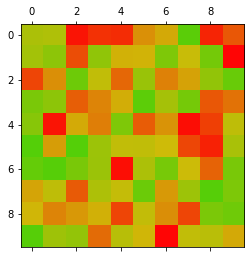

In [ ]:
import matplotlib.colors as clr
import numpy as np
some_matrix = np.random.rand(10,10)
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ["#54cf08",'#cfbb08','#ff0505'], N=256)
plt.matshow(some_matrix, cmap=cmap)
# plt.show()

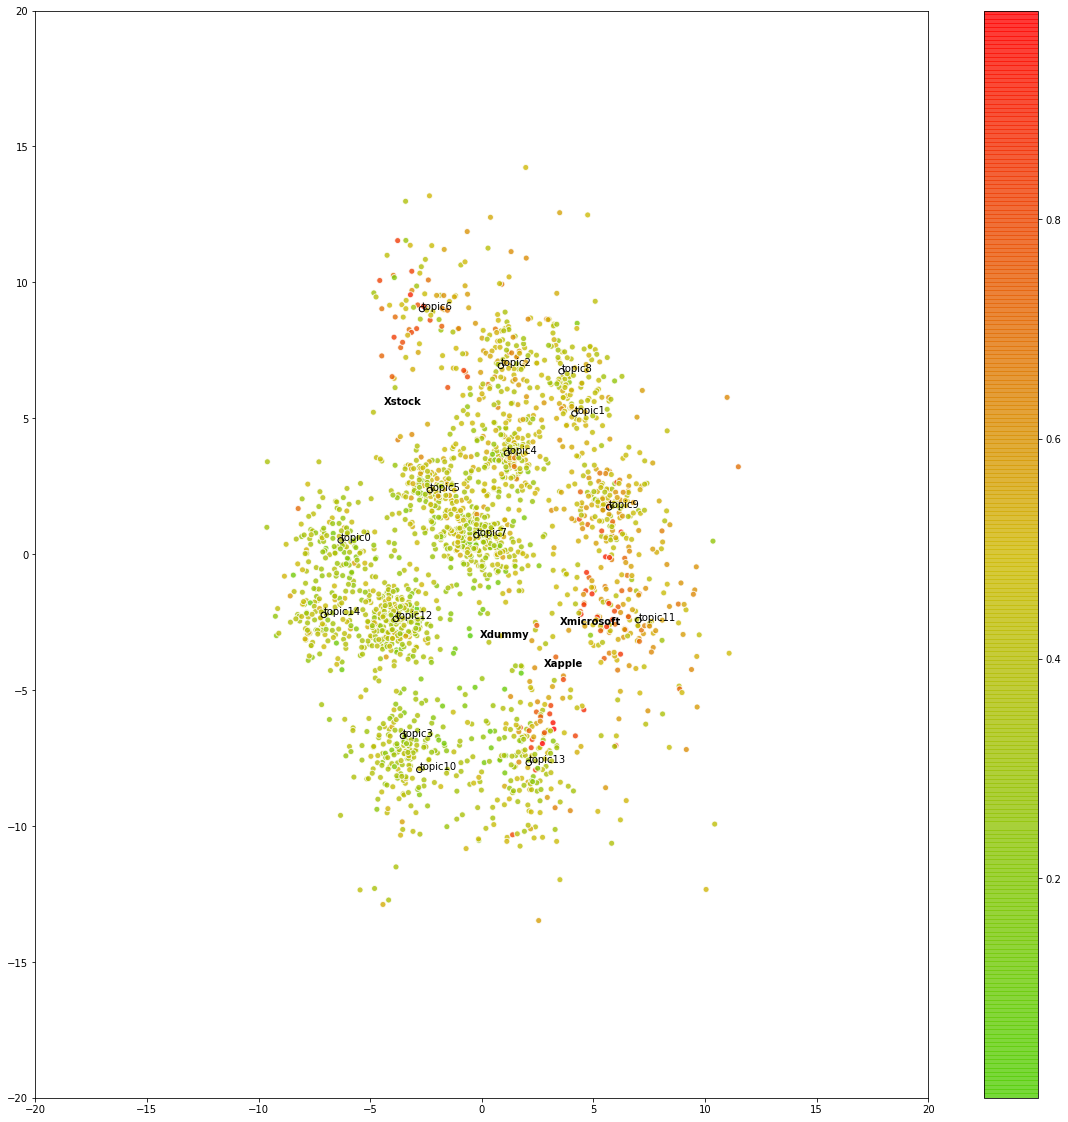

In [ ]:
plot_heatmap(x_list,docs_rscore,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# # scaled_dist = scaler.fit_transform(dist_doc_key[:,len(keywords)].reshape(-1,1))

# min_d_ok = torch.min(dist_doc_key[:,:-1],-1).values
# scaled_dist = scaler.fit_transform(min_d_ok.reshape(-1,1))
# plot_heatmap(x_list,1-min_d_ok,zphi,query_words,keyword_vis_labels,cmap=newcmp,lim=20)

# ____ STOP____

In [ ]:
STOP!!!!

SyntaxError: ignored

In [ ]:
STOP!!!!

In [ ]:
STOP!!!!

# Furthur Evaluation (TTM etc..)

In [ ]:
## ToDo

# vis of bbc, searchsnippet: Foto, TTM, WTM: 10, 20, 30 topics, old beta, heatmap
# sum cosine scores top words (10, 20)

In [ ]:
# New Beta cos (for long text) -
# softmax((\tau*\keyEmbT)*\cos)
# ------------------------------
# 0: democracy korean representative star actress action war republic actor amazon stanford college party asian photo school info president critic life
# 1: news wikipedia business computer system online game resource encyclopedia health web wiki sport article theory journal service book program link
# 2: physic computer service device sale digital theme drama software music performance radio field journal internet database program driver development company
# 3: gov team news product topic global issue cover solution management source article consumer overview history application division multi learn system
# 4: drama art classical dance character literature beatles ballet architecture television fashion cup artist photography literary philosopher doctor museum film movie
# 5: solving square maintenance implication enabling lose monitoring roadmap amp disaster handling monitor vendor problem control environmental solution recovery function measure
# 6: movie culture film school democracy college star actor war blog republic car chinese forum tom character action doctor actress football
# 7: korean eng representative gov korea sun star democracy actress spotlight dennis powered action doc ngo head israel bush men cross
# 8: science music art yahoo political library market search student course theoretical site video job american fashion graduate philosophy digital museum
# 9: democracy korean representative star actress action war republic actor amazon stanford college party asian photo school info president critic life
# ------------------------------
# ['korean', 'drama']

# --------------------------------------- VS -------------------------------------------
# Old Beta cos (For short text)
# softmax ( (\omegaT*\tau).cos)
# ------------------------------
# 0: game sport news football wikipedia soccer team league player tennis match ticket wiki espn article club website racing encyclopedia olympic
# 1: computer software network memory web drug intel system electrical linux server device company virtual download motor core processor source document
# 2: wikipedia journal theory computer program system web science university article wiki paper theoretical programming encyclopedia physic center data link engineering
# 3: amazon book history wikipedia car house online film encyclopedia award video model search american people photo event production community wiki
# 4: business health gov market service trade cancer economic product management news disease national bank global exchange federal stock resource public
# 5: party democracy political war system republic government democratic presidential election president income parliamentary politics automatic stress people europe representative tax
# 6: movie culture imdb star news american oscar film actor disney tom director george ancient robert character cartoon guide biography leonardo
# 7: science school library news student yahoo course directory job education online resource graduate study search site philosophy physical degree master
# 8: gov engine calorie military healthy hiv diet theorem food diagnosis aid fitness force hospital earth medical weapon north legislation weight
# 9: music art fashion digital band artist lyric review wheel rock album classical romantic video piano painting camera pop designer television
# ------------------------------
# ['korean', 'drama']

In [ ]:
import plotly.express as px
def plot_relv_topwords(keywords,np_topics_wordsScores):
  for i in range(len(keywords)):
    fig = px.histogram(pd.DataFrame(np_topics_wordsScores[i],columns=['scores']), x="scores")
    print(keywords[i])
    fig.show()
# print("Spike Slab Filter (top # relv words that represents documents):",spikeSlab_filter,"\n\n")

In [ ]:
## How much are the topic topwords relevant to keywords
## (Calc using cosine sim score)
# with_cos_score_more_than = 0.45

all_topics = get_topwords(beta,id_vocab,topwords=30)
topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
# topic_key_idx = [flatten_topics_wordlist.index(k) for k in keywords]
np_flatten_topics_wordlist = np.array(flatten_list(topics_wordlist))
topics_wordtensors = get_embedding_tensor(np_flatten_topics_wordlist,embeddings)

topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cosine_sqrt)
# np_topics_wordsScores = torch_min_max_sim(list_of_tensors_to_tensor(topics_wordsScores),topic_key_idx,3)
np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
# relv_topic_words = flatten_topics_wordlist[np.where(topics_wordsScores>with_cos_score_more_than)[0]]
# relv_topic_words , len(relv_topic_words)
len(np_flatten_topics_wordlist)

In [ ]:
keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores)

In [ ]:
# save_obj(beta,'beta_'+d_data)
# save_obj(id_vocab,'id_vocab_'+d_data)
# save_obj(keywords,'keywords_'+d_data)
# !zip -r bbc_results_t15_3k_FoTo.zip *.pkl

In [ ]:
!wget -N -c https://www.dropbox.com/s/s0xi2fnk5kz72wx/ttm_more_results.zip
!unzip -o ttm_more_results.zip

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
# % cd /content/short
mypath = "/content/short"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
csv_files = []
for o in onlyfiles:
  for k in keywords:
    if k+"-PT-5-1-Iter-250" in o and "target-keyword" in o:
      csv_files.append(o)

## get all words
all_words = []
for c in csv_files:
  df = pd.read_csv(c)
  words = df.values.reshape(-1)
  words_cleaned = [a for a in words if str(a).isalpha() == True and str(a) != 'nan']
  all_words.extend(words_cleaned[:150])
all_words = np.asarray(all_words)

topics_wordtensors = get_embedding_tensor(all_words,embeddings)
topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cosine_sqrt)
np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
# len(all_words)

In [ ]:
keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores)

In [ ]:
## how to select topwords for TTM if topics have empty topwords?
## the cosine score is as per the embeddings we generated is that fair?

# Save/Download Results

In [ ]:
STOP!!

In [ ]:
doc_ids_model = [i.item() for i in doc_ids]

In [ ]:
save_obj(get_topwords(beta, id_vocab),"top100_docmodel_"+d_data)

In [ ]:
save_obj(x_list,"x_list")
save_obj(indices,"doc_id_desm")
save_obj(doc_ids_model,"doc_ids_model")
save_obj(labels_list,"labels_list")
save_obj(all_rscores,"all_rscores")
save_obj(keywords,'keywords_'+d_data)

In [ ]:
from google.colab import files
files.download("doc_ids_model.pkl")
files.download("doc_id_desm.pkl")
files.download("x_list.pkl")
files.download("labels_list.pkl")
files.download("all_rscores.pkl")
files.download("keywords_"+d_data+".pkl")
files.download("top100_docmodel_"+d_data+".pkl")

In [ ]:
rm -r *.pkl*